# Imaging biomarker extraction walkthrough
This notebook will go over some examples of extacting biomarkers from structural T1 weighted MR images and amyloid PET data. These are some of the most widely used biomarkers that are used in AD research. They are also measures used in the EBM.

## Objectives
After completing this notebook, you will be able to:
* Understand how to open and interrogate meddical imaging data
* Run basic image processing tasks like image registration and segmentation
* Extract measurements of brain volumes and amyloid burden.

 There are many different publicly available, open-source software packges that you can use to obtain these measurements.  The specific techniques that we are using in this notebook are meant to demonstrate the key concepts involved in the processing pipelines, but they have not been optimised for this task. The exact decision of what software and pipeline to use for your research  will depend on what works best for your data and application.

## Preparation
First, we will import the packages that will be used in our notebook. We will be using the following packages:
* [nibabel](https://nipy.org/nibabel/) - a handy package to work with neuroimaging data.
* [Advanced Normalisation Toolbox (ANTs)](https://antspy.readthedocs.io/en/latest/index.html) - a popular set of tools that do registration, segmentation and other image processing techniques. 
* [Niwidgets](https://github.com/nipy/niwidgets) - a small package for making interactive viewers in Jupyter notebooks. This is useful for a quick view of an image.
* [fsleyes](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FSLeyes)(OPTIONAL)- a popular, fully featured image visualisation tool. It does have [support for Jupyter notebooks](https://open.win.ox.ac.uk/pages/fsl/fsleyes/fsleyes/userdoc/fsleyes_notebook.html). You might find this easier to interactively review your results rather than using the static plots provided here.    

In [ ]:
%%capture --no-display
%matplotlib inline
import os
import nibabel as nb
import numpy as np
from niwidgets import NiftiWidget
import pandas as pd
import ants
import matplotlib.pyplot as plt

# If using dark background, then keep the next line in, otherwise comment it out.
plt.style.use('dark_background')


We are also going to make a handy function to write out the imaging data so that we can look at it outside of the notebook.

In [ ]:
def write_image(image_to_write,rootdir,subject,image_type,image_desc,image_space=None):
    if image_space is not None:
        image_name = f"sub-{subject}_space-{image_space}_desc-{image_desc}.nii.gz"
    else:
        image_name = f"sub-{subject}_desc-{image_desc}.nii.gz"
    image_path = os.path.join(rootdir,image_type,image_name)
    ants.image_write(image_to_write,image_path)
    

## Imaging basics
The first step that we are going to do is load in an image and have a quick look at it. There are many different file formats used in medical imaging data, but the two most common are the _Digital Image and COmmunication in Medicine_ ([DICOM](https://www.dicomstandard.org/current))and the _Neuroimaging InFormatics Technology Initiative_ ([NIFTI](https://nifti.nimh.nih.gov/#:~:text=NIfTI%2D1%20is%20a%20new,MRI%20data%20analysis%20software%20packages.). In both cases, data is stored as a flat sheet (two-dimensional image data) or a cube (three-dimensional) where individual elements of the data are called pixels (2-D) or voxels (3-D). At every pixel or voxel, there is one or more numerical values associated with each element. These values could represent many different quantitites:
* Scalar (single numeric value per voxel): intensity, a label identifying a structure
* Vector/Array/Tensor (multiple numeric values): such as RGB colour values, a time series or multiple values acquired from the same sequence. 

Associated with this data is _metadata_ which describes key aspects of the image. This metadata could describe, among other things, how the data was acquired, information about the patient, how big the image is, how to map this image into the real world in the context of otehr images, and how the data for each pixel is represented.


### Opening an image
Let's first load in an image stored in the Nifti file format into memory and see some basic information about it. One nice thing about Nifti is that you can _compress_ the image using gzip, which makes the image much smaller on your hard drive (roughoy 30-50% for images and up to 90-95% for binary masks), but most software packages can still read it without decomressing it (though it will still take up the same amount of memory when loaded up for viewing and analysis)

**Note: If you want to run this yourself while on the course, download the data from the TeamCoders Team channel and change the data_root variable to match the location on your computer**

In [ ]:
data_root="/Users/davecash/Data/IDEAS/TeamCoder_EBM/bids"
subject_id="011-S-4906"
bids_desc = "t1"
subject_root = os.path.join(data_root,"sub-"+subject_id)
t1_img_name = os.path.join(subject_root,"anat","sub-" + subject_id + "_desc-" + bids_desc + ".nii.gz")
t1_img = nb.load(t1_img_name)
print(f"Dimensons {t1_img.shape}")
print(f"Distance and Time Units: {t1_img.header.get_xyzt_units()}")
print(f"Voxel spacing: {t1_img.header.get_zooms()}")

This first line of output comes from printing out the shape field from the structure that we have creatingn by reading the Nifti image file using nb.load. It says we have a cube of imaging data in the file that contains 176 columns, 240 rows, and 256 slices.  The second row of output descibes the units used to describe the image. For distance we are using millimeters and for time we are using seconds. The final line of output indicates the size that each voxel represents, which is 1.2 x 1.0 x 1.0 mm. This inforatioon will be useful in a little while.

Now lets find out what this image data contains. While we have loaded in the image, we have not yet loaded in the large cube of numbers that represents the image data. First we are going to do that by using the `get_fdata()` command. Once we have the large cube loaded in, we are  going to find a test voxel and ask for its intensity. We typically denote voxel locations as *i*, *j*, and *k*. Here we choose a test voxel location of (100,100,100) which means we want to know the intensity of the voxel at row 100 and column 100 within slice 100. 


In [ ]:
test_voxel = (100,100,100)
t1_img_data = t1_img.get_fdata()
print(t1_img_data[test_voxel])

Python starts counting at **zero**, so this row 100 is actually the 101st row in the matrix. It also means that the indices used to access the voxels inside the array go from rows 0 to 175, not 1 to 176, and columns from 0 to 239, not 1 to 240. Watch what happens if I want to get the first row and column in the last slice if I think Python is counting from 1.

In [ ]:
first_voxel_in_last_slice=(1,1,256)
print(t1_img_data[first_voxel_in_last_slice])

Let's move on from an individual voxel to the entire image. I want to know what the minimum and maximum intensities are over the entire image. How do I do that?

In [ ]:
# Get the minimum and maximum
img_min = t1_img_data.min()
img_max = t1_img_data.max()
print(f"Minimum: {img_min}")
print(f"Maximum: {img_max}")

## From voxels to the real world
Now we are able to look at voxels, but how do we know where they are in the real world? An MRI of a fruit fly or an elephant could contain 256 slices, but one image would have to represent a much larger size in the real world than the other. What if the elephant was sideways in the scanner, but the fruit fly had its head towards the top of the scanner and its tail at the bottom? Then the rows and columns would mean entirely different anatomical directions!

Embedded in the images metadata are not only the dimensions of each voxel, but also an important transformation, or mapping, that tells us how to convert the voxel location *(i,j,k)* to the real-world coordinates of *(x,y,z)*. Understanding this mapping is very important, as we will be needing this information to align images later. This transformation is stored in the affine field of the nifti imaging strucutre as it is stored by nibabel. 

The real-world coordinate system tends to be defined according to the patient. The x-axis tends to go from patient left to patient right, the y axis tends to go from anterior to posterior, and the z-axis goes from top to bottom of the patient. 
The below image from [Slicer](https://www.slicer.org/wiki/Coordinate_systems) explains this concept in more detail.
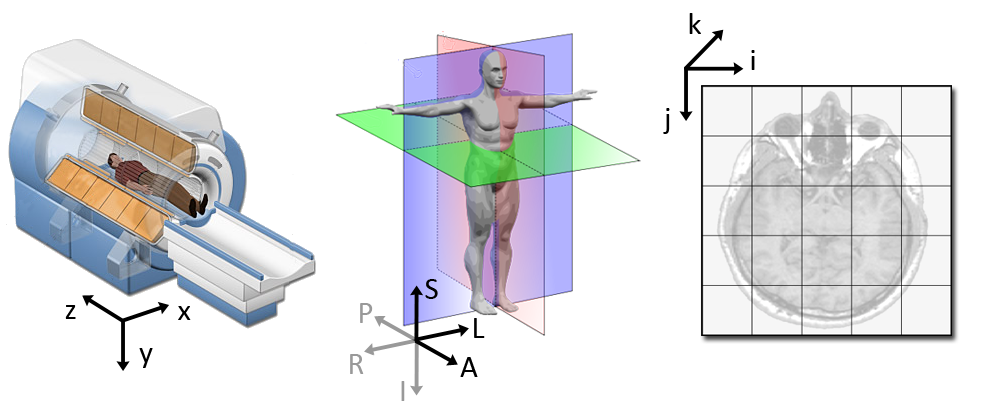

In [ ]:
np.set_printoptions(suppress=True)
print(t1_img.affine)

The output shows the affine transformation which is represented as a four by four matrix. The first 3 rows and columns represent how we *rotate* and *scale* the image voxel to get it into real worlsd space. Here all the numbers off the main diagonal are 0, indicating that there is no rotation, so the image is in an orientation that is aligned with the cardinal axes of the scanner in the real world as shown in the figure above. That means that the rows of voxels go from left to right in the real world and the columns go from the patients front to the patients back, and finally the slices go from the top of the head down towards the neck. As we saw in a previous cell, we know the dimensions of each voxel, so as we move one voxel over in the X direction, we are moving 1.2mm in real world space, and in the other directions we are moving 1.0 mm in real world space. 

The first three numbers in the final column that are all quite large represent the *translation* or shift we need to move the voxel into real-world space. The bottom row is always 0,0,0,1 and is used to make it easier to map one or thousands of points in one single matrix operation. 

This process can easily be _inverted_ so that we can provide the real world coordinates and get the corresponding voxel location back. This is important for when we want to know what the corresponding voxel intensity is when comparing two images. 

How do we map a voxel to its real-world coordinates from the voxel location? We use a process known as matrix multiplication.

In [ ]:
voxel_loc = (100,100,100,1)
real_world = t1_img.affine.dot(voxel_loc)
np.set_printoptions(precision=2)
print(f"Voxel location: {voxel_loc}")
print(f"Real World coordinates: {real_world}")

So this means that the voxel (100,100,100) represents physical space (16.4 mm. -2.7 mm, -52.8 mm). When we have different kinds of images acquired in the scanning session or in other scanning sessions, then may have different orientations or different voxel sizes, then it makes it easier to compare and overlay the images together. We will see a bit more abotu that when we discuss registration. Now that we know a bit more about how to traverse the images and what they mean. Let's take a look at one! The niwdiget below plots it in your notebook. However, you can also look at it in the command line using the tool fsleyes

In [ ]:
%%capture --no-display
niwidget = NiftiWidget(t1_img_name)
niwidget.nifti_plotter()

## Bias correction
When looking at this image, particularly in `fsleyes`, you may notice how the white matter has some gentle fluctations in intensity. It slowly varies from darker areas to lighter areas. This is due to the fact that the static magnetic field, known as $B_0$, is not perfectly constant everywhere. There are small fluctuations that slowly vary over the volume of the head that cause these subtle differences in intensity. These  differences can cause issues for subsequent processing routines needed to get accurate measures of brain volume. 

In order to reduce this effect, we employ a technique known as d _bias correction_, which  normalises the intensity across the image. For this tutorial, we are going to be using one of the most common bias correction algorithms out there, [N3](https://www.nitrc.org/docman/view.php/6/880/sled.pdf). Other software packages, like [SPM](https://www.fil.ion.ucl.ac.uk/spm/), integrate bias correction with the[tissue segmetnation](#tissue-segmentation) step.  

The code below will perform the bias correction and then plot out images of the original image in the top row, the corrected image in the middle row and the difference between them in the bottom row. Notice how smooth the bias field is across the image. 

Let's also save the T1 N3 and T1_diff outputs so that we can see them in fsleyes. 


In [ ]:

t1_img = ants.image_read(t1_img_name)
t1_n3 = ants.n3_bias_field_correction(t1_img)
t1_diff = t1_img - t1_n3
ants.plot_ortho_stack([t1_img,t1_n3,t1_diff])
write_image(t1_n3,rootdir=subject_root,subject=subject_id,image_type="anat",image_desc="t1-n3")
write_image(t1_diff,rootdir=subject_root,subject=subject_id,image_type="anat",image_desc="bias-field")


## Brain extraction
Before we perform the [tissue segmentation](#tissue-segmentation) step, we are going to do a bit more pre-processing. Some tissue segmetnation algorithms require the removal of most of the non-brain structures (neck, eyes, skull, dura, eta) leacing only the brain parenchyma and surrounding cerebrospinal fluid. This process is often known as _skull stripping_ or _brain extraction_.  

There are many different ways to do this, bt we are going to a very simple method to illustrate the process. More advanced methods, which might work better for your analysis that you want to do, are available.

We are going to grap a standard atlas called [MNI152](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/Atlases). This comes with a handy mask of the brain. We are going to register, or align this atlas to our image and then transfer the mask to our image, and this should provide a starting point to remove non-brain tissue.

However, if we open the image below (and in `fsleyes`). You can see the atlas much bigger and in a different part of the image than the other. they are also not in the same orientation. This is beause their voxels represent different parts of the coordinate system.

In [ ]:
atlasdir = os.path.join(data_root,"atlas")
mni_img_file = os.path.join(atlasdir,"MNI152_T1_1mm.nii.gz")
mni_img = ants.image_read(mni_img_file)
mni_mask_file = os.path.join(atlasdir,"MNI152_T1_1mm_brain_mask_dil.nii.gz")
mni_mask = ants.image_read(mni_mask_file)
ants.plot_ortho_double(image=mni_img, image2=mni_img,
                       overlay=mni_mask, overlay2=mni_mask, overlay_cmap2="Reds_r",
                       overlay_alpha=0.0, overlay_alpha2=0.4,title="MNI image and mask",title_dy=0.25)

In [ ]:
ants.plot_ortho_double(image=mni_img,image2=t1_n3,title="Before Registration",title_dy=0.25)

So now we are going to run a _registration_, which determines the optimal mapping from the coordinate system in our image into the coordinate system of the atlas and vice versa. Registrations can be a tricky if we don't provide a good starting guess. We will use the affine_initializer to quickly determine a good starting point. 

In [ ]:
init_tx_file = ants.affine_initializer(fixed_image = mni_img, moving_image = t1_n3, mask = mni_mask)
init_tx = ants.read_transform(init_tx_file)
t1_mni_init = ants.apply_transforms(fixed = mni_img, moving = t1_n3,transformlist=init_tx_file)

Now let's take a look at the image and see if we have improved.

In [ ]:

ants.plot_ortho_double(image=mni_img,image2=t1_mni_init,title="After Initialisation",title_dy=0.25)

That appears to be improved compared to the unaligned images, but there is still a fair amount of work to do. Now that we have a better starting point, we will run the full registration. .

In [ ]:
affine = ants.registration(fixed = mni_img, moving = t1_n3, type_of_transform = "Affine", initial_transform = init_tx_file, mask = mni_mask)

Now what does that registration produce? Let's print out the return value to see what it holds

In [ ]:
print(affine)

This output is somewhat cryptic. From the [ANTSpy documentation](https://antspy.readthedocs.io/en/latest/index.html), this output is a dictionary that holds four elements:
* _warpedmovout_: Moving image warped to space of fixed image. 
* _warpedfixout_: Fixed image warped to space of moving image. 
* _fwdtransforms_: Transforms to move from moving to fixed image. 
* _invtransforms_: Transforms to move from fixed to moving image.

To see how the registration has performed, we are going to look at the fixed image (the MNI atalas) and the moving image transfored into the fixed space (warpedmovout).

In [ ]:
ants.plot_ortho_double(image=mni_img,image2=affine['warpedmovout'],title="Affine Registration",title_dy=0.25)

The registration appears to have worked, and the imags are well aligned. In registration terminology, the _forward mapping_ moves our moving image into the coordinate system described by the fixed image (MNI), while the _inverse mapping_ moves the fixed image into the space of our image. These mappings are completely symmetric, so we can move forward and backward between image coordinate systems without losing any information.

We can also  apply the mappings to other images that use the same coordinate systems. Here we are transforming the mask generated in MNI space into our coordinate system. 

In [ ]:
t1_mask = ants.apply_transforms(fixed = t1_n3, moving = mni_mask,transformlist=affine['fwdtransforms'],interpolator="nearestNeighbor",whichtoinvert=[True])
ants.plot_ortho_double(image=t1_n3, image2=t1_n3, scale=True,scale2=True,overlay=t1_mask, overlay2=t1_mask,overlay_cmap2="Reds_r",
                       overlay_alpha=0.0, overlay_alpha2=0.4,title="T1 image and transferred brain mask",title_dy=0.25)

By using the registration, we have transferred the mask from our MNI image, which appears to cover all of the brain, but excluding almost all of the non-brain tissue. 

We are now going to use some utilities to finish the brain extraction. We are going to use `mask_image` to preserve all of the intensities of our image that are inside the mask while making all the values outside the mask zero. This is called a _masked image_. We will then use the maksed image to further clean up our brain mask using the `get_mask` command. .

In [ ]:
t1_brain = ants.mask_image(t1_n3,t1_mask)
t1_mask_cleaned = ants.get_mask(t1_brain,cleanup=3)
t1_brain_cleaned = ants.mask_image(t1_n3,t1_mask_cleaned)
ants.plot_ortho_stack([t1_n3,t1_brain,t1_brain_cleaned],title="Original, Skull-stripped original, Skull-stripped clean")

If you compare the second row and the third row, you can see an additional bit of the connective tissue at the top and front of the brain has been removed.

## Tissue segmentation
Next we are going to run a step of identifying tissue types within the brain. The brain is typically divided up into three primary tissue types: 
1. grey matter (GM),
2. white matter (WM), and
3. cerebrospinal fluid (CSF)

In [ ]:
tissue_seg = ants.atropos(a=t1_n3,x=t1_mask_cleaned,m="[0.3,1x1x1]", i='Kmeans[3]')

The resulting images provide a binary image (second row) of the most likely label (1 for CSF, 2 for GM, 3 for WM), as well as probablistic maps (bottom three rows) of how much of each tissue (a value between 0.0 and 1.0) is contained within each voxel.

We have saved the binary images so that you can look at them in fsleyes, but looking at the probability maps (shown below the segmentation) is also helpful in some cases as well. 

In [ ]:

ants.plot_ortho_stack([t1_n3,tissue_seg['segmentation'],tissue_seg['probabilityimages'][0],
tissue_seg['probabilityimages'][1],tissue_seg['probabilityimages'][2]],title="Tissue Segmentation Results")
write_image(tissue_seg['segmentation'],rootdir=subject_root,
subject=subject_id,image_type="anat",image_desc="t1-bin-seg")

We can also extract some important statitics about each tissue type. From the output below, we can see that the background (LabelValue=0) has the lowest mean intensity, followed by CSF, then GM, and WM. The volume of the GM is about 574 ml (or 574373 $mm^3$).

In [ ]:
tissue_stats = ants.label_stats(t1_n3,tissue_seg['segmentation'])
print(tissue_stats)

## Brain parcellation
We have identified tissue types, but could we go further and identify the correct anatomical brain structure that each voxel belongs to? This step is called _brain parcellation_ as extremely helpful for many applications, whether to get volumes of individual structures or to use them to define a region of interest (ROI) to obtain summary metrics for multimodal analysis, where the other imaging moodalities don't provide such high resolution or fine anatomical definition. 

There are many packages out there to do this. Many of the most widely-used approaches take a considerable amount of time (anywhere from an hour to a whole day). For your workbook, consider running another model (FreeSurfer, FastSurfer, ANTS, etc) on your own.
For the purpose of this demo, we are going to take a similar approach to the one used in the [brain extraction](#brain-extraction) section. This involves taking an atlas which has already been labelled and transferring those labels to our image.  

Many people use the [Automated Anatomical Labelling (AAL)](https://www.gin.cnrs.fr/en/tools/aal/) atlas for this purpose. We will first open that data up and have a look at it.

In [ ]:
# Determine template, rigid + SYN and then transfer labels over. 
aal_template_file = os.path.join(atlasdir,"AAL3v1_1mm.nii.gz")
aal_template = ants.image_read(aal_template_file).astype("uint32")
aal_img_file = os.path.join(atlasdir,"single_subj_T1.nii")
aal_img = ants.image_read(aal_img_file)
ants.plot_ortho_double(image=aal_img,image2=aal_img, scale=True,scale2=True, overlay=aal_template,overlay2=aal_template,
                      overlay_alpha=0.0,title="AAL Image and Labels",title_dy=0.25)

This time we are not only going to do an affine registration, but also a nonrigid registration to warp the tempalte to match our image and get a very detailed and more exact mapping between images. This is quite a challenge for the algorithm, as the AAL tempalte is based on a single healthy 27 year old, while our subjects come from an Alzheimer's Disease cohort where most of the population are over 70.

This will take about four or five minutes to run. You are welcome to chop and change the setting to see if you can get improved registration.

In [ ]:
ants.plot_ortho_double(image=t1_n3, image2=aal_img, scale=True,scale2=True,
                       title="Before Registration",title_dy=0.25)

In [ ]:
t1_mask_dil = ants.iMath(t1_mask_cleaned,'MD',2)
aal_affine_init_file = ants.affine_initializer(fixed_image = t1_n3,moving_image = aal_img)
syn_aal = ants.registration(fixed=t1_n3,moving=aal_img,mask=t1_mask_dil,
type_of_transform="SyN",initial_transform=aal_affine_init_file,
reg_iterations=(60,30,15))

When we look at the images, they appear to be reasonably well aligned. The venticles are a good area to check as they are typically much larger in older indiiduals and would hae been expanded to match our image. You may also notice the wavy bits in the bright fat regions near the skull in the top of warped tempalte. That is likely because we have told the algorithm to focus only on the brain and not the surrounding areas so these regions do not have to fit very well for the registration to achieve a good alignment. 

In [ ]:
ants.plot_ortho_double(image=t1_n3, image2=syn_aal['warpedmovout'], scale=True,scale2=True,
                       title="After Registration",title_dy=0.25)


The next step is to use the results from the registration to warp the labels into our image. We are only using one subject to do this, where specific variations in anatomy between your source of the labels and the image you want to label. In fact, many groups now use an approach that consists of a _template library_, which contains tens to hundreds of labelled images from individuals with different anatomy and conditions. For each image in the template library, they repeat this process of transferring the labels to the new image using non-rigid registration. This results in the same number of candidate labellings as there are images in the template library. The final step is to resolve differences between the candidate abellins to build one consensus labelling, a step known as _label fusion_. The overall process is often called _multi atlas label fusion_.


In [ ]:
t1_aal_label = ants.apply_transforms(fixed = t1_n3, moving = aal_template,transformlist=syn_aal['fwdtransforms'],interpolator="genericLabel")
ants.plot_ortho_double(image=t1_n3,image2=t1_n3,overlay=t1_aal_label,overlay2=t1_aal_label,
                       scale=True,scale2=True,
                      overlay_alpha=0.0,title="Transferred labels",title_dy=0.25)
write_image(syn_aal['warpedmovout'], rootdir=subject_root,subject = subject_id, image_type="anat",
image_desc = "aal-resampled")
write_image(t1_aal_label, rootdir=subject_root,subject = subject_id, image_type="anat",
image_desc = "aal-labels")



We can get stats from this image just as we got stats from the tissue segmentation. The label values aren't helpful on their own, so we are adding in the descriptions to see which structures are associated with which labels.

In [ ]:
aal_stats = ants.label_stats(t1_n3,t1_aal_label)
df_aal = pd.read_table(os.path.join(atlasdir,"AAL3v1_1mm.nii.txt"),
names=["LabelName","LabelValue"],delim_whitespace=True)
df_aal = df_aal.set_index("LabelValue")
aal_stats = aal_stats.set_index("LabelValue")
aal_stats = aal_stats.join(df_aal)
aal_stats = aal_stats[["LabelName","Volume","Mean","Min","Max","Variance"]]
print(aal_stats)

The below plot comes from using the freeSurfer pipeline to do the parcellation. I ran this data using the following command in Freesurfer 7.2.0:

`recon-all -subject 011_S_4906 -i bids/sub-011-S-4906/anat/sub-011-S-4096_desc-t1-adni-preproc.nii.gzz -all -threads 4`

This approach takes 3-6 hours to run on machines, and you can see the substanial imprvoement in the images as a result. 

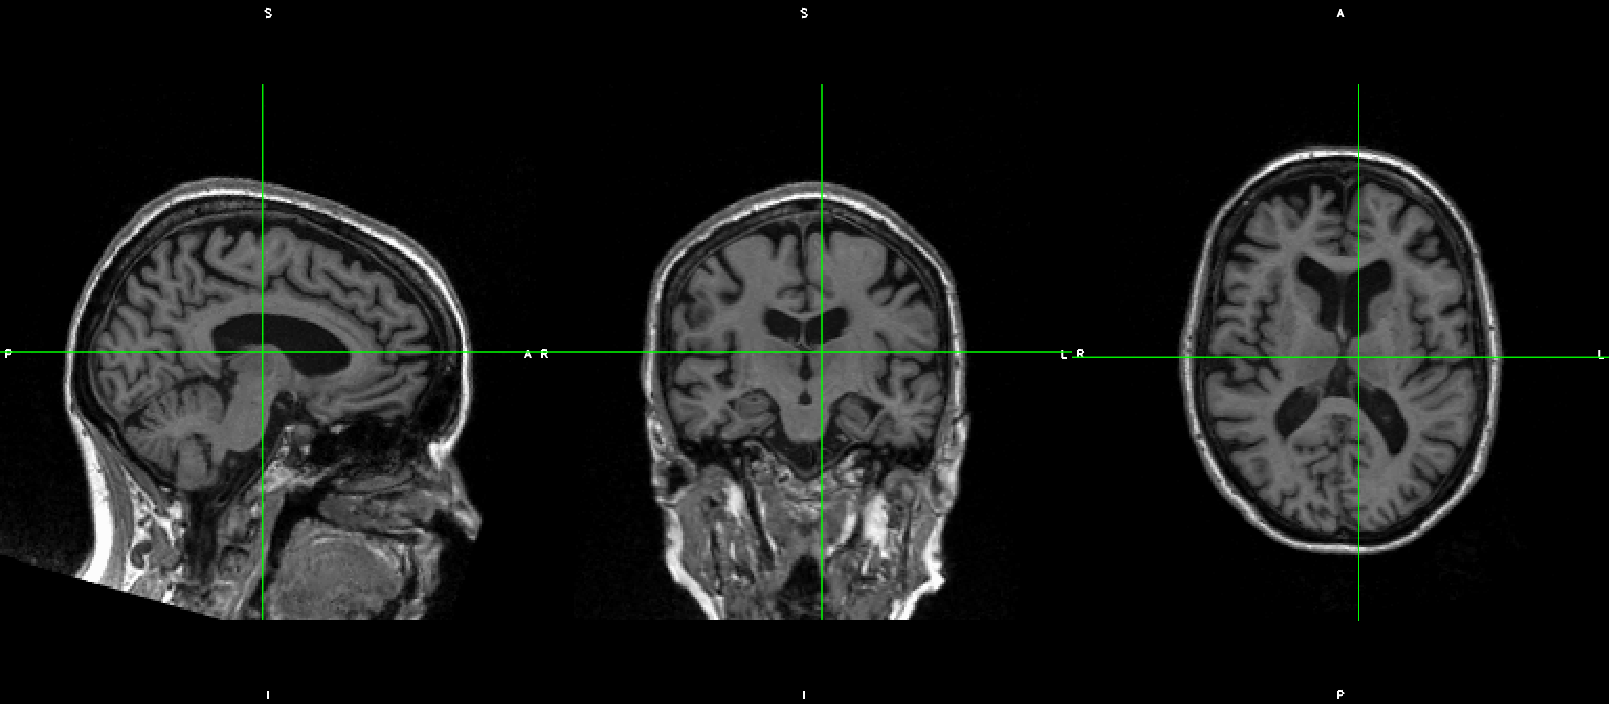

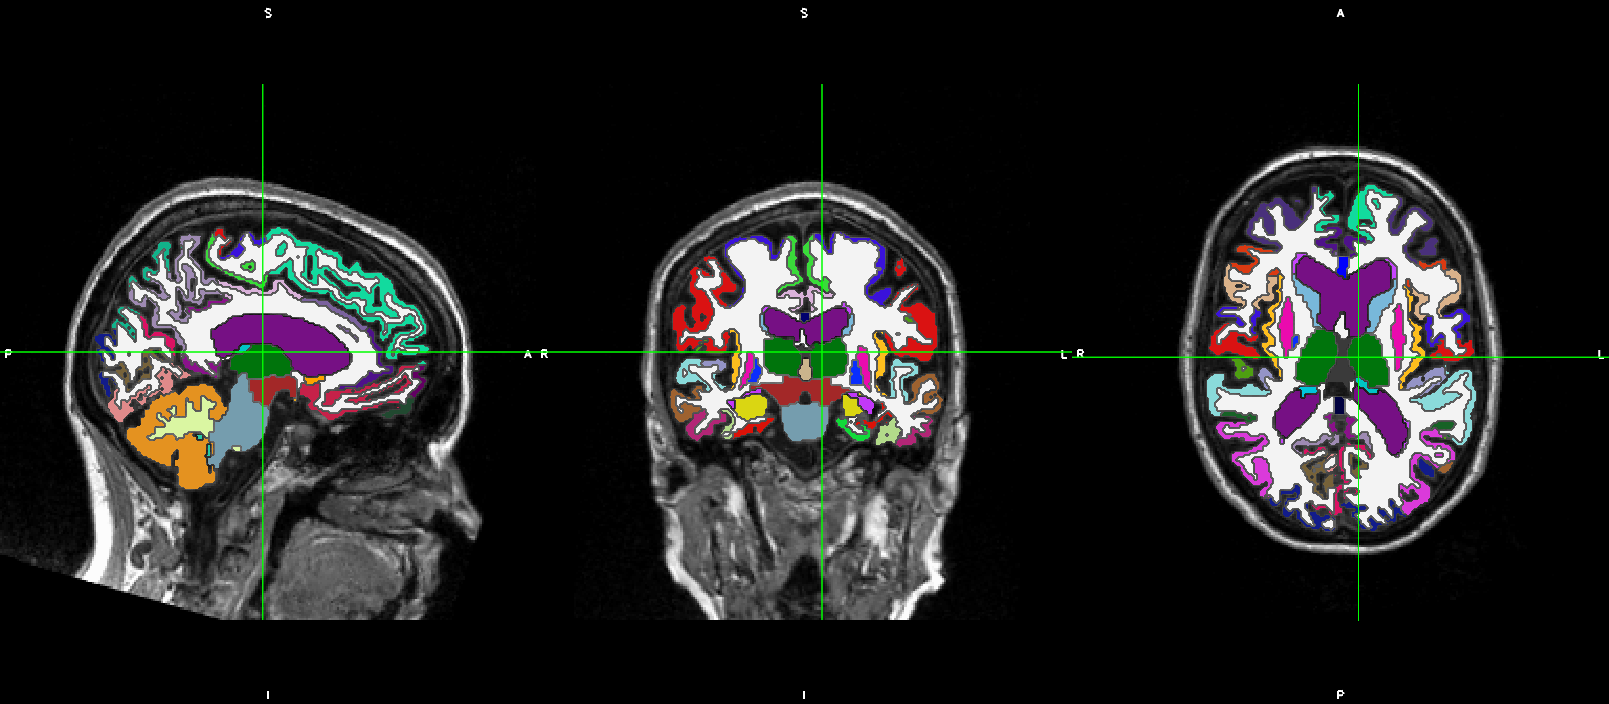

In [ ]:
# See if we can clean this up, perhaps nibabel to read in?
# Also do the label image trick.
fsdir="/Users/davecash/Data/freesurfer"
t1_fs_nu_name  = os.path.join(fsdir,subject_id.replace("-","_"),"mri","nu.mgz")
t1_fs_nu = ants.image_read(t1_fs_nu_name)
t1_fs_aparc_name = os.path.join(fsdir,subject_id.replace("-","_"),"mri","aparc+aseg.mgz")
t1_fs_aparc = ants.image_read(t1_fs_aparc_name).astype("uint32")


## Co Registration
We have seen registration used above to match a standard atlas to our image. Now we are going to use it to align our PET data with our MRI data. 
Registration is used for many pipelines. The main goal is to determine the optimal mapping to align corresponding anatomy between it can be used to align different modalities together (for example PET to MR) to a standard space (such as MNI152) and to

In [ ]:
bids_desc = "av45-adni-preproc"
av45_name = os.path.join(subject_root,"pet","sub-" + subject_id + "_desc-" + bids_desc + ".nii.gz")
av45 = ants.image_read(av45_name)
pet_to_mri = ants.registration(fixed = t1_fs_nu,moving=av45,type_of_transform="Rigid")
ants.plot_ortho_double(image=t1_fs_nu,image2=t1_fs_nu,overlay=t1_fs_nu,overlay_alpha=0.0,
                       overlay2=pet_to_mri['warpedmovout'], overlay_alpha2=0.55,
                       scale=True,scale2=True,title="Co-registered MRI and PET", title_dy=0.25)
fs_nu_in_pet = ants.apply_transforms(fixed=av45, moving=t1_fs_nu,whichtoinvert=[True],
transformlist=pet_to_mri['fwdtransforms'],interpolator="bSpline")
fs_aparc_in_pet = ants.apply_transforms(fixed=av45, moving=t1_fs_aparc,whichtoinvert=[True],
transformlist=pet_to_mri['fwdtransforms'],interpolator="genericLabel")


We will write these out so that you can take a look in `fsleyes`, which will provide an easier way to see the labels of this image in PET space. 

In [ ]:
write_image(fs_nu_in_pet,rootdir = subject_root, subject= subject_id,
image_type="anat",image_space="av45",image_desc="t1-fs-nu")
write_image(fs_aparc_in_pet,rootdir = subject_root, subject= subject_id,
image_type="anat",image_space="av45",image_desc="t1-fs-aparc")
ants.plot_ortho_double(image=av45,image2=av45,scale=True,scale2=True,
                       overlay=fs_aparc_in_pet, overlay_alpha=0.0,
                       overlay2=fs_aparc_in_pet, overlay_alpha2=0.7,
                       title="T1 labels transferred to PET", title_dy=0.25)

The images, and most importantly the labels look well aligned. So we will now proceed with getting the statistics out of these images.

In [ ]:
pet_stats = ants.label_stats(av45,fs_aparc_in_pet)
pet_stats["LabelValue"] = pet_stats['LabelValue'].astype("int")
pet_stats = pet_stats.set_index("LabelValue")
df_aparc = pd.read_csv(os.path.join(data_root,"aparc_aseg_roi.csv"),index_col=0)
pet_stats = pet_stats.join(df_aparc)
pet_stats = pet_stats[["LabelName","Volume","Mean","Min","Max","Variance"]]
print(pet_stats)


The question now is what do these numbers mean? From ADNI's website, it states that they are " intensity normalized using a subject-specific mask so that the average of voxels within the mask is exactly one" But that doesn't make for helpful comparison across subjects. In PET, we tend to normalise on a _reference region_, like the white matter or the cerebellum where there is little specific uptake of the tracer and produce values known as _standardised uptake value ratios_.

We don't need to do any additional image processing for this. This can be done by just re-normalising the values using the new reference region. We just need to determine the mean activity over all of the regionsn that represents the cerebellum (label values 7,8,46,47). Then, we normalise all the values by this mean activity and we have the SUVR. We will save the resulting data so you can take a look at it in Excel.      

In [ ]:
pet_stats["TotalUptake"] = pet_stats["Volume"] * pet_stats["Mean"]
cerebellum_rows = pet_stats["LabelName"].map(lambda x: "Cerebellum" in x)
sum_volume = pet_stats[cerebellum_rows]['Volume'].sum()
sum_uptake = pet_stats[cerebellum_rows]['TotalUptake'].sum()
mean_ref = sum_uptake / sum_volume
pet_stats["SUVR"] = pet_stats["Mean"] / mean_ref
print(pet_stats[cerebellum_rows])
print(sum_volume)
print(sum_uptake)
print(pet_stats)
pet_stats.to_csv(os.path.join(subject_root,"pet","sub-"+subject_id+"_desc-av45-stats.csv"))